In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
import warnings
warnings.filterwarnings('ignore')

# Import our modules
import sys
sys.path.append('..')
from src import (
    Config, load_model_and_tokenizer,
    extract_all_layer_representations
)
from src.datasets import TemporalDataset

# Ensure plots display inline
%matplotlib inline


Loading model...
Loading model: meta-llama/Llama-3.2-1B
Model loaded with 16 layers


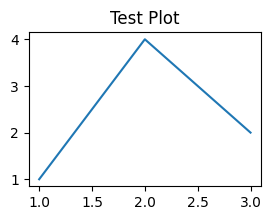

In [2]:
# Initialize
config = Config()
config.batch_size = 32

# Load model
print("Loading model...")
model, tokenizer = load_model_and_tokenizer(config)
print(f"Model loaded with {model.config.num_hidden_layers} layers")

# Quick test plot to ensure matplotlib is working
plt.figure(figsize=(3, 2))
plt.plot([1, 2, 3], [1, 4, 2])
plt.title("Test Plot")
plt.show()


In [3]:
# Dataset 1: WITHOUT multiples of 7 (standard)
def create_dataset_without_multiples_7(config):
    """Create dataset excluding multiples of 7."""
    data = []
    days = config.days_of_week
    offsets = [x for x in range(2, 71) if x % 7 != 0]  # Exclude multiples of 7
    template = config.CONTEXT_TEMPLATES['add_plur']
    
    for day_idx, day in enumerate(days):
        for offset in offsets:
            result_idx = (day_idx + offset) % 7
            result_day = days[result_idx]
            text = template.format(day, offset, result_day)
            data.append({
                'text': text,
                'day': day_idx,
                'offset': offset,
                'result_day': result_idx
            })
    return data

# Dataset 2: WITH ALL numbers including multiples of 7
def create_dataset_with_all_numbers(config):
    """Create dataset with all numbers from 2-70."""
    data = []
    days = config.days_of_week
    offsets = list(range(2, 71))  # All numbers from 2 to 70
    template = config.CONTEXT_TEMPLATES['add_plur']
    
    for day_idx, day in enumerate(days):
        for offset in offsets:
            result_idx = (day_idx + offset) % 7
            result_day = days[result_idx]
            text = template.format(day, offset, result_day)
            data.append({
                'text': text,
                'day': day_idx,
                'offset': offset,
                'result_day': result_idx
            })
    return data

# Create both datasets
print("Creating datasets...")
data_without_7 = create_dataset_without_multiples_7(config)
data_with_all = create_dataset_with_all_numbers(config)

df_without_7 = pd.DataFrame(data_without_7)
df_with_all = pd.DataFrame(data_with_all)

print(f"Dataset without multiples of 7: {len(df_without_7)} examples")
print(f"Dataset with all numbers (including multiples of 7): {len(df_with_all)} examples")
print(f"\nMultiples of 7 in full dataset: {[x for x in range(2, 71) if x % 7 == 0]}")
print(f"Number of multiples of 7: {len([x for x in range(2, 71) if x % 7 == 0])}")

# Show example data points
print("\nExample data points:")
print("Without multiples of 7:")
print(df_without_7[['text', 'day', 'offset', 'result_day']].head(3))
print("\nWith all numbers (showing a multiple of 7):")
print(df_with_all[df_with_all['offset'] == 7][['text', 'day', 'offset', 'result_day']].head(3))


Creating datasets...
Dataset without multiples of 7: 413 examples
Dataset with all numbers (including multiples of 7): 483 examples

Multiples of 7 in full dataset: [7, 14, 21, 28, 35, 42, 49, 56, 63, 70]
Number of multiples of 7: 10

Example data points:
Without multiples of 7:
                                  text  day  offset  result_day
0  Monday plus 2 days equals Wednesday    0       2           2
1   Monday plus 3 days equals Thursday    0       3           3
2     Monday plus 4 days equals Friday    0       4           4

With all numbers (showing a multiple of 7):
                                       text  day  offset  result_day
5          Monday plus 7 days equals Monday    0       7           0
74       Tuesday plus 7 days equals Tuesday    1       7           1
143  Wednesday plus 7 days equals Wednesday    2       7           2


In [4]:
# Function to extract embeddings
def extract_embeddings(df, model, tokenizer, device):
    """Extract embeddings from all layers for a dataset."""
    texts = df['text'].tolist()
    encodings = tokenizer(texts, truncation=True, padding=True, 
                         return_tensors='pt', max_length=128)
    dataset = TemporalDataset(encodings, df)
    layer_representations, labels = extract_all_layer_representations(
        model, dataset, device
    )
    return layer_representations, labels

# Extract embeddings
print("\nExtracting embeddings for dataset WITHOUT multiples of 7...")
embeddings_without_7, labels_without_7 = extract_embeddings(
    df_without_7, model, tokenizer, config.device
)

print("\nExtracting embeddings for dataset WITH ALL numbers (including multiples of 7)...")
embeddings_with_all, labels_with_all = extract_embeddings(
    df_with_all, model, tokenizer, config.device
)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Extracting embeddings for dataset WITHOUT multiples of 7...


Extracting representations: 100%|██████████| 26/26 [00:05<00:00,  5.15it/s]



Extracting embeddings for dataset WITH ALL numbers (including multiples of 7)...


Extracting representations: 100%|██████████| 31/31 [00:06<00:00,  5.11it/s]


In [5]:
# Apply PCA to each layer for both datasets
pca_results_without_7 = {}
pca_results_with_all = {}

num_layers = len(embeddings_without_7)

for layer_idx in range(num_layers):
    # PCA for dataset without multiples of 7
    pca_without = PCA(n_components=2)
    transformed_without = pca_without.fit_transform(embeddings_without_7[layer_idx])
    
    # PCA for dataset with all numbers (including multiples of 7)
    pca_with = PCA(n_components=2)
    transformed_with = pca_with.fit_transform(embeddings_with_all[layer_idx])
    
    pca_results_without_7[layer_idx] = {
        'transformed': transformed_without,
        'pca': pca_without,
        'variance_explained': pca_without.explained_variance_ratio_
    }
    
    pca_results_with_all[layer_idx] = {
        'transformed': transformed_with,
        'pca': pca_with,
        'variance_explained': pca_with.explained_variance_ratio_
    }

print(f"PCA applied to {num_layers} layers for both datasets")


PCA applied to 17 layers for both datasets


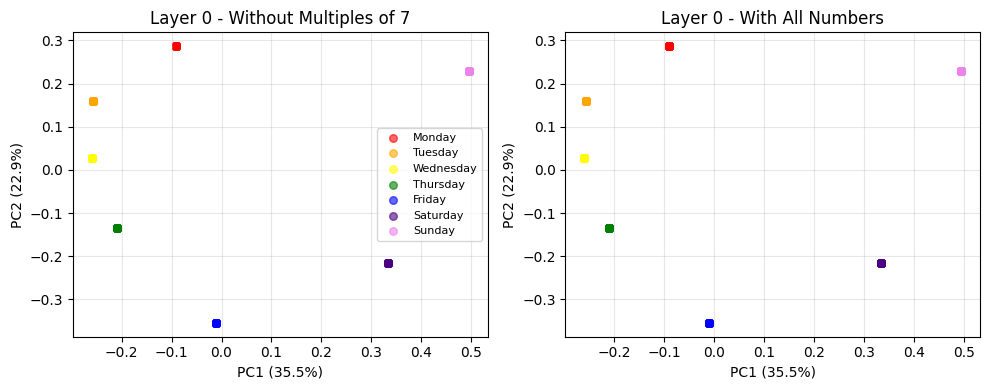

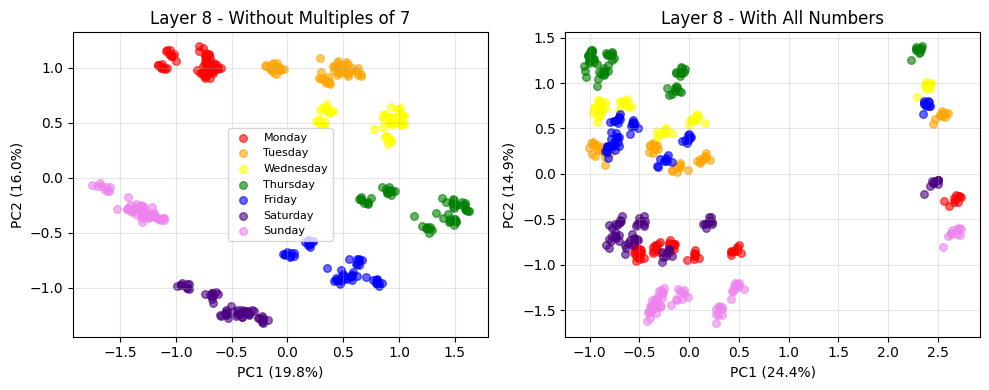

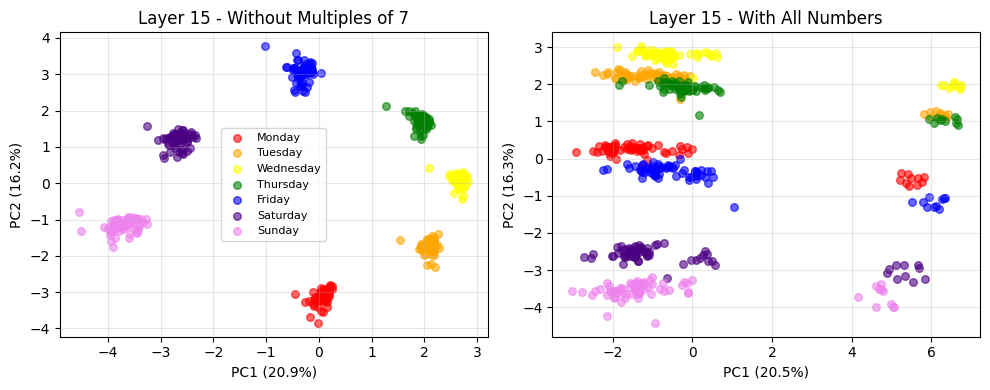

Plotted layers: [0, 8, 15]

Creating grid view of all layers...


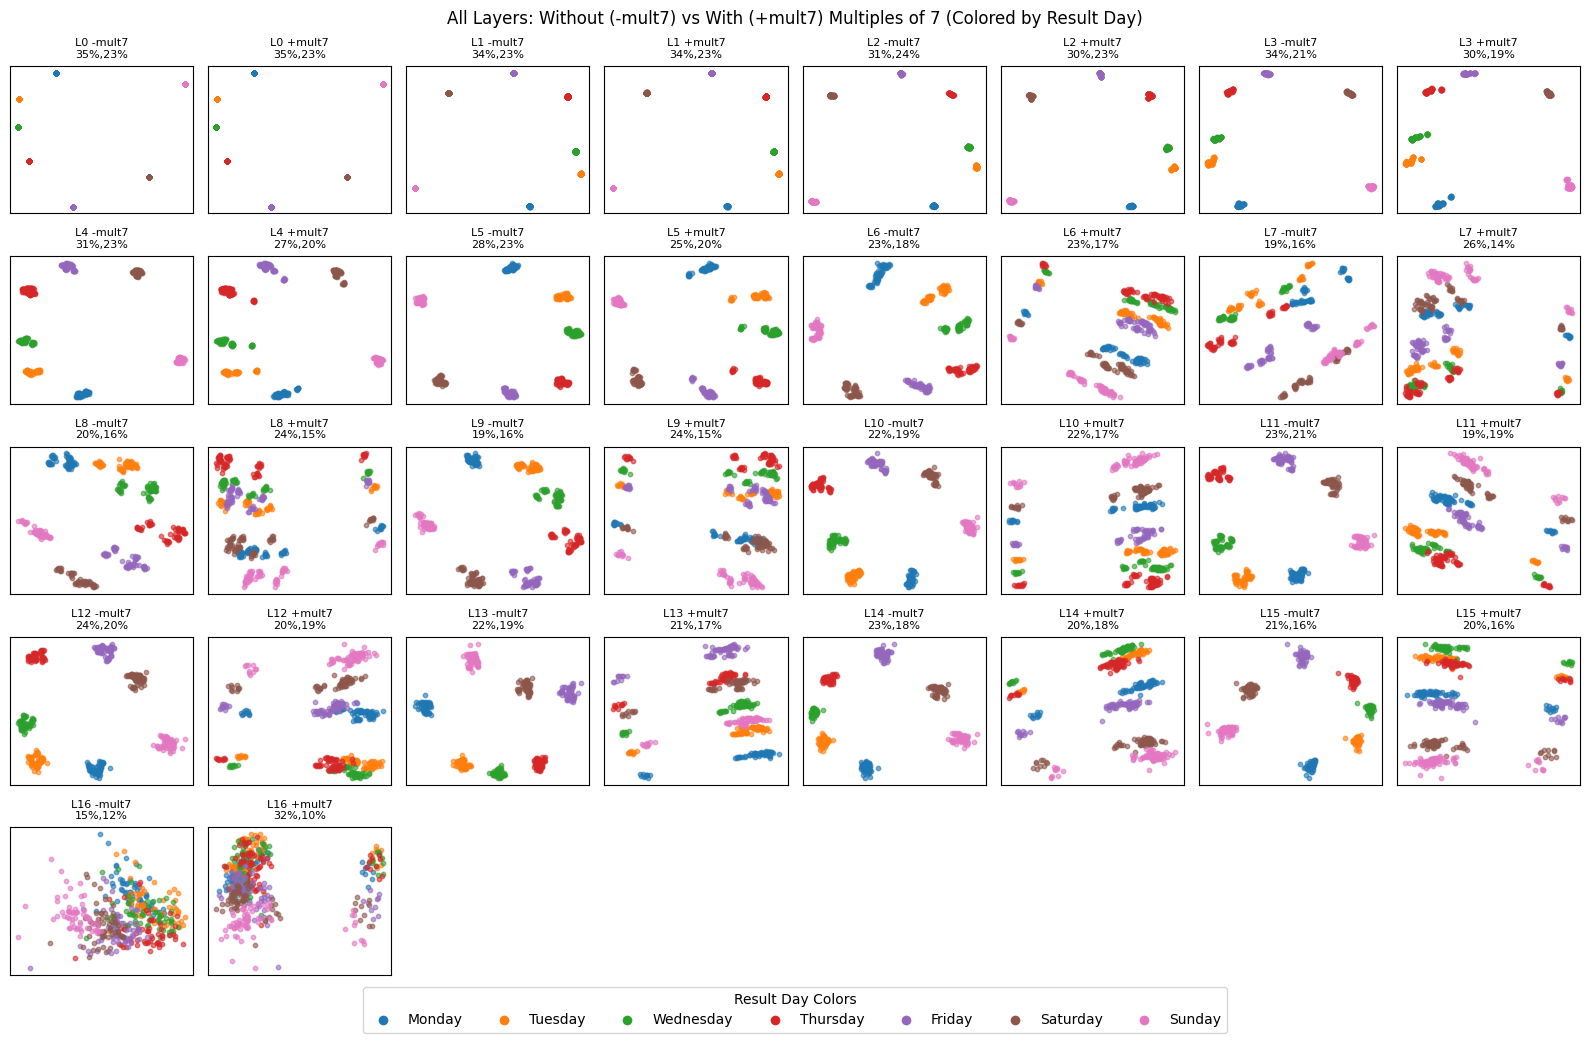

In [6]:
# Simple comparison - plot a few layers to debug
layers_to_show = [0, 8, 15] if num_layers > 15 else [0, num_layers//2, num_layers-1]

for layer_idx in layers_to_show:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Colors for days
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet']
    
    # Left: Without multiples of 7
    transformed = pca_results_without_7[layer_idx]['transformed']
    var_explained = pca_results_without_7[layer_idx]['variance_explained']
    
    # Color by RESULT day, not starting day
    result_days_without = df_without_7['result_day'].values
    for result_day in range(7):
        mask = result_days_without == result_day
        if np.any(mask):
            ax1.scatter(transformed[mask, 0], transformed[mask, 1],
                       c=colors[result_day], label=config.days_of_week[result_day], s=30, alpha=0.6)
    
    ax1.set_title(f'Layer {layer_idx} - Without Multiples of 7')
    ax1.set_xlabel(f'PC1 ({var_explained[0]:.1%})')
    ax1.set_ylabel(f'PC2 ({var_explained[1]:.1%})')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Right: With all numbers
    transformed = pca_results_with_all[layer_idx]['transformed']
    var_explained = pca_results_with_all[layer_idx]['variance_explained']
    
    # Color by RESULT day, not starting day
    result_days_all = df_with_all['result_day'].values
    for result_day in range(7):
        mask = result_days_all == result_day
        if np.any(mask):
            ax2.scatter(transformed[mask, 0], transformed[mask, 1],
                       c=colors[result_day], label=config.days_of_week[result_day], s=30, alpha=0.6)
    
    ax2.set_title(f'Layer {layer_idx} - With All Numbers')
    ax2.set_xlabel(f'PC1 ({var_explained[0]:.1%})')
    ax2.set_ylabel(f'PC2 ({var_explained[1]:.1%})')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
print(f"Plotted layers: {layers_to_show}")

# Now create a grid view of all layers
print("\nCreating grid view of all layers...")
n_cols = 8  # 4 layers × 2 datasets per row
n_rows = (num_layers * 2 + n_cols - 1) // n_cols

fig = plt.figure(figsize=(16, n_rows * 2))

# Simple color mapping
day_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Get result days arrays once
result_days_without = df_without_7['result_day'].values
result_days_all = df_with_all['result_day'].values

plot_idx = 1
for layer_idx in range(num_layers):
    # Plot without multiples of 7
    ax = plt.subplot(n_rows, n_cols, plot_idx)
    transformed = pca_results_without_7[layer_idx]['transformed']
    var = pca_results_without_7[layer_idx]['variance_explained']
    
    # Color by RESULT day
    for result_day in range(7):
        mask = result_days_without == result_day
        ax.scatter(transformed[mask, 0], transformed[mask, 1], 
                  c=day_colors[result_day], s=10, alpha=0.6)
    
    ax.set_title(f'L{layer_idx} -mult7\n{var[0]:.0%},{var[1]:.0%}', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Plot with all numbers
    plot_idx += 1
    ax = plt.subplot(n_rows, n_cols, plot_idx)
    transformed = pca_results_with_all[layer_idx]['transformed']
    var = pca_results_with_all[layer_idx]['variance_explained']
    
    # Color by RESULT day
    for result_day in range(7):
        mask = result_days_all == result_day
        ax.scatter(transformed[mask, 0], transformed[mask, 1], 
                  c=day_colors[result_day], s=10, alpha=0.6)
    
    ax.set_title(f'L{layer_idx} +mult7\n{var[0]:.0%},{var[1]:.0%}', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plot_idx += 1

plt.suptitle('All Layers: Without (-mult7) vs With (+mult7) Multiples of 7 (Colored by Result Day)', fontsize=12)
plt.tight_layout()

# Add a color legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=day_colors[i], markersize=8, 
                             label=config.days_of_week[i]) 
                   for i in range(7)]
plt.figlegend(handles=legend_elements, loc='lower center', ncol=7, 
              title="Result Day Colors", bbox_to_anchor=(0.5, -0.05))
plt.show()


In [7]:
# Simple variance comparison across layers
print("Variance Explained by First 2 PCs:")
print("\nLayer | Without Multiples of 7  | With All Numbers")
print("-" * 50)

for layer in range(num_layers):
    var1 = pca_results_without_7[layer]['variance_explained']
    var2 = pca_results_with_all[layer]['variance_explained']
    print(f"  {layer:2d}  | PC1: {var1[0]:.1%}, PC2: {var1[1]:.1%} | PC1: {var2[0]:.1%}, PC2: {var2[1]:.1%}")


Variance Explained by First 2 PCs:

Layer | Without Multiples of 7  | With All Numbers
--------------------------------------------------
   0  | PC1: 35.5%, PC2: 22.9% | PC1: 35.5%, PC2: 22.9%
   1  | PC1: 34.4%, PC2: 23.2% | PC1: 34.3%, PC2: 23.2%
   2  | PC1: 31.5%, PC2: 23.5% | PC1: 30.2%, PC2: 22.6%
   3  | PC1: 34.0%, PC2: 20.9% | PC1: 30.4%, PC2: 18.9%
   4  | PC1: 30.9%, PC2: 22.7% | PC1: 27.1%, PC2: 20.0%
   5  | PC1: 28.3%, PC2: 22.9% | PC1: 24.8%, PC2: 20.1%
   6  | PC1: 22.7%, PC2: 18.5% | PC1: 22.7%, PC2: 17.1%
   7  | PC1: 19.0%, PC2: 15.9% | PC1: 25.6%, PC2: 13.6%
   8  | PC1: 19.8%, PC2: 16.0% | PC1: 24.4%, PC2: 14.9%
   9  | PC1: 19.3%, PC2: 16.4% | PC1: 24.0%, PC2: 14.9%
  10  | PC1: 21.6%, PC2: 19.2% | PC1: 22.4%, PC2: 16.9%
  11  | PC1: 23.1%, PC2: 21.2% | PC1: 19.3%, PC2: 18.6%
  12  | PC1: 23.6%, PC2: 20.3% | PC1: 19.6%, PC2: 18.9%
  13  | PC1: 22.0%, PC2: 19.2% | PC1: 20.5%, PC2: 17.3%
  14  | PC1: 23.0%, PC2: 17.5% | PC1: 20.4%, PC2: 18.1%
  15  | PC1: 20.9%, PC

In [8]:
print("Dataset 1 (Without multiples of 7):")
print(f"- {len(df_without_7)} examples")
print("- Excludes: [7, 14, 21, 28, 35, 42, 49, 56, 63]")

print("\nDataset 2 (With all numbers):")  
print(f"- {len(df_with_all)} examples")
print("- Includes all offsets 2-70")

print("\nMultiples of 7 are identity operations where:")
print("Monday + 7 days = Monday, Tuesday + 14 days = Tuesday, etc.")

print("\n🎨 COLOR CODING:")
print("Points are colored by the RESULT day (the answer), not the starting day.")
print("For example: 'Saturday + 1 day = Sunday' is colored as Sunday (violet)")
print("This shows how the model groups together all operations that lead to the same result day.")


Dataset 1 (Without multiples of 7):
- 413 examples
- Excludes: [7, 14, 21, 28, 35, 42, 49, 56, 63]

Dataset 2 (With all numbers):
- 483 examples
- Includes all offsets 2-70

Multiples of 7 are identity operations where:
Monday + 7 days = Monday, Tuesday + 14 days = Tuesday, etc.

🎨 COLOR CODING:
Points are colored by the RESULT day (the answer), not the starting day.
For example: 'Saturday + 1 day = Sunday' is colored as Sunday (violet)
This shows how the model groups together all operations that lead to the same result day.
